## Portfolio Market Risk 

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Tuple, Dict, List

from scipy.stats import norm, gaussian_kde


In [37]:
def simulate_multivariate_log_returns(
    mu: np.ndarray,
    cov: np.ndarray,
    dt: float,
    n_sims: int,
    seed: int = 42
) -> np.ndarray:
    """
    R ~ N(mu*dt, cov*dt) for log-returns over horizon dt.
    mu shape: (d,)
    cov shape: (d,d)
    Returns: (n_sims, d) matrix of log-returns
    """
    mu = np.asarray(mu, dtype=float).reshape(-1)
    cov = np.asarray(cov, dtype=float)
    d = mu.shape[0]
    if cov.shape != (d, d):
        raise ValueError("cov must be (d,d) and match mu length")

    rng = np.random.default_rng(seed)
    L = np.linalg.cholesky(cov * dt)  # Cholesky of covariance over dt

    Z = rng.standard_normal(size=(n_sims, d))
    R = (mu * dt) + (Z @ L.T)
    return R


def evolve_prices_from_log_returns(S0: np.ndarray, R: np.ndarray) -> np.ndarray:
    """
    S_T = S0 * exp(R) applied elementwise.
    S0 shape: (d,)
    R shape: (n_sims, d)
    Returns: S_T shape (n_sims, d)
    """
    S0 = np.asarray(S0, dtype=float).reshape(1, -1)
    return S0 * np.exp(R)


def simulate_gbm_prices(
    S0: np.ndarray,
    mu: np.ndarray,
    vol: np.ndarray,
    corr: np.ndarray,
    dt: float,
    n_sims: int,
    seed: int = 42
) -> np.ndarray:
    """
    Multivariate GBM with correlated Brownian shocks.
    log-return i: (mu_i - 0.5 vol_i^2)*dt + vol_i*sqrt(dt)*eps_i
    with corr among eps.
    """
    S0 = np.asarray(S0, dtype=float).reshape(-1)
    mu = np.asarray(mu, dtype=float).reshape(-1)
    vol = np.asarray(vol, dtype=float).reshape(-1)
    corr = np.asarray(corr, dtype=float)

    d = len(S0)
    if len(mu) != d or len(vol) != d or corr.shape != (d, d):
        raise ValueError("Dimensions mismatch among S0, mu, vol, corr")

    rng = np.random.default_rng(seed)
    C = np.linalg.cholesky(corr)

    Z = rng.standard_normal(size=(n_sims, d))
    eps = Z @ C.T

    drift = (mu - 0.5 * vol**2) * dt
    shock = vol * np.sqrt(dt) * eps
    R = drift + shock
    return evolve_prices_from_log_returns(S0, R)


In [39]:
def bs_call_price(S: float, K: float, r: float, sigma: float, T: float) -> float:
    if T <= 0:
        return max(S - K, 0.0)
    if sigma <= 0:
        return max(S - K * np.exp(-r * T), 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def bs_call_delta_gamma(S: float, K: float, r: float, sigma: float, T: float) -> Tuple[float, float]:
    """
    Returns (delta, gamma) for a European call.
    """
    if T <= 0 or sigma <= 0:
        # At expiry or zero vol, delta/gamma are not smooth; use safe approximations
        delta = 1.0 if S > K else 0.0
        gamma = 0.0
        return delta, gamma

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    pdf_d1 = norm.pdf(d1)
    delta = norm.cdf(d1)
    gamma = pdf_d1 / (S * sigma * np.sqrt(T))
    return float(delta), float(gamma)


In [41]:
@dataclass
class CallOption:
    underlying_index: int   # which asset in S vector
    K: float
    sigma: float
    T: float                # time-to-maturity in years
    position: float         # + = long, - = short


@dataclass
class Portfolio:
    stock_positions: np.ndarray      # shares per asset, shape (d,)
    call_options: List[CallOption]   # list of option positions


def value_portfolio_full(
    S: np.ndarray,          # asset prices shape (d,)
    portfolio: Portfolio,
    r: float
) -> float:
    """
    Full revaluation: stocks at market + options by Black–Scholes with current S and remaining T.
    """
    S = np.asarray(S, dtype=float).reshape(-1)
    v_stocks = float(np.dot(portfolio.stock_positions, S))

    v_opts = 0.0
    for opt in portfolio.call_options:
        price = bs_call_price(
            S=S[opt.underlying_index],
            K=opt.K,
            r=r,
            sigma=opt.sigma,
            T=opt.T
        )
        v_opts += opt.position * price

    return v_stocks + v_opts


In [43]:
def value_portfolio_delta_gamma_approx(
    S0: np.ndarray,
    S1: np.ndarray,
    portfolio: Portfolio,
    r: float
) -> float:
    """
    Approximate portfolio value at S1 using delta-gamma expansion around S0 for options,
    while stocks are exact linear anyway.

    V(S1) ≈ V(S0) + sum_i delta_i * dS_i + 0.5 * sum_i gamma_i * (dS_i)^2
    (Here we only use diagonal gammas for simplicity.)
    """
    S0 = np.asarray(S0, dtype=float).reshape(-1)
    S1 = np.asarray(S1, dtype=float).reshape(-1)
    dS = S1 - S0

    # Exact stock value at S1
    v_stocks = float(np.dot(portfolio.stock_positions, S1))

    # Options: delta-gamma approx from S0
    v_opts0 = 0.0
    dv_opts = 0.0
    for opt in portfolio.call_options:
        i = opt.underlying_index
        price0 = bs_call_price(S0[i], opt.K, r, opt.sigma, opt.T)
        delta, gamma = bs_call_delta_gamma(S0[i], opt.K, r, opt.sigma, opt.T)

        v_opts0 += opt.position * price0
        dv_opts += opt.position * (delta * dS[i] + 0.5 * gamma * (dS[i] ** 2))

    # Approx option value at S1
    v_opts1_approx = v_opts0 + dv_opts
    return v_stocks + v_opts1_approx


In [45]:
def var_es(losses: np.ndarray, alpha: float = 0.99) -> Tuple[float, float]:
    losses = np.asarray(losses, dtype=float)
    losses = losses[np.isfinite(losses)]
    var = float(np.quantile(losses, alpha, method="linear"))
    tail = losses[losses >= var]
    es = float(tail.mean()) if len(tail) else np.nan
    return var, es


def plot_loss_distribution(losses: np.ndarray, alpha: float = 0.99, bins: int = 60, title: str = "Loss Distribution"):
    losses = np.asarray(losses, dtype=float)
    losses = losses[np.isfinite(losses)]

    v, e = var_es(losses, alpha=alpha)

    plt.figure()
    plt.hist(losses, bins=bins, density=True)

    # optional KDE
    try:
        kde = gaussian_kde(losses)
        grid = np.linspace(losses.min(), losses.max(), 400)
        plt.plot(grid, kde(grid), linewidth=2, label="KDE")
    except Exception:
        pass

    plt.axvline(v, linewidth=2, label=f"VaR {alpha:.2%} = {v:,.2f}")
    plt.axvline(e, linewidth=2, label=f"ES  {alpha:.2%} = {e:,.2f}")
    plt.xlabel("Loss (L = V0 - V_T)")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [47]:
# ----- Risk factor setup -----
d = 2  # number of assets
S0 = np.array([100.0, 80.0])     # today prices
mu = np.array([0.06, 0.04])      # annual drift (can set 0 for risk-neutral-ish demo)
vol = np.array([0.20, 0.25])     # annual vols
corr = np.array([[1.0, 0.3],
                 [0.3, 1.0]])

# Convert vol+corr to covariance of log-returns (annualized)
cov = np.outer(vol, vol) * corr

# Horizon
dt = 1/252  # 1 trading day
alpha = 0.99
n_sims = 200_000
r = 0.03    # risk-free rate for option repricing

# ----- Portfolio setup -----
# Stocks: 10 shares of asset 0, 5 shares of asset 1
stock_pos = np.array([10.0, 5.0])

# Options: long 20 calls on asset0 (K=100), 30 days to maturity
opt = CallOption(underlying_index=0, K=100.0, sigma=0.20, T=30/365, position=20.0)

portfolio = Portfolio(stock_positions=stock_pos, call_options=[opt])

# Current portfolio value (V0)
V0 = value_portfolio_full(S0, portfolio, r=r)
V0


1448.1916289215892

In [49]:
# Simulate multivariate log-returns and evolve prices
R = simulate_multivariate_log_returns(mu=mu, cov=cov, dt=dt, n_sims=n_sims, seed=7)
S_T = evolve_prices_from_log_returns(S0, R)  # shape (n_sims, d)

# Revalue portfolio in each scenario
# Decrease option time-to-maturity by dt (can't go below 0)
portfolio_T = Portfolio(
    stock_positions=portfolio.stock_positions.copy(),
    call_options=[
        CallOption(
            underlying_index=o.underlying_index,
            K=o.K,
            sigma=o.sigma,
            T=max(o.T - dt, 0.0),
            position=o.position
        ) for o in portfolio.call_options
    ]
)

V_T = np.array([value_portfolio_full(S_T[i], portfolio_T, r=r) for i in range(n_sims)])
L = V0 - V_T  # losses

VaR, ES = var_es(L, alpha=alpha)
VaR, ES


(60.37875203971649, 67.97879186349091)

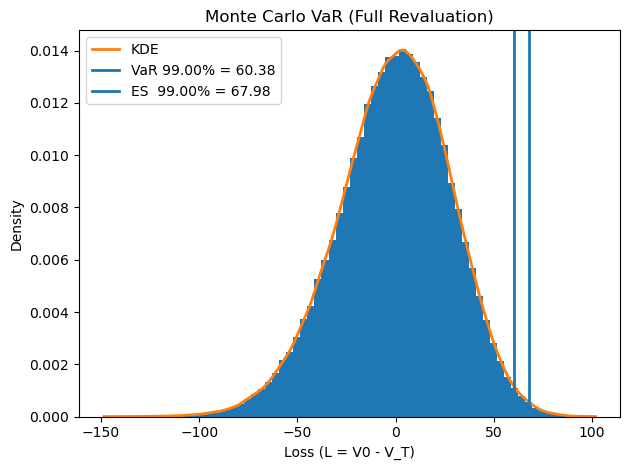

In [50]:
plot_loss_distribution(L, alpha=alpha, bins=70, title="Monte Carlo VaR (Full Revaluation)")


In [ ]:
# Approximate revaluation: stocks exact + options delta-gamma around S0
V_T_dg = np.array([value_portfolio_delta_gamma_approx(S0, S_T[i], portfolio_T, r=r) for i in range(n_sims)])
L_dg = V0 - V_T_dg

VaR_dg, ES_dg = var_es(L_dg, alpha=alpha)
(VaR, ES), (VaR_dg, ES_dg)


In [ ]:
plot_loss_distribution(L_dg, alpha=alpha, bins=70, title="Monte Carlo VaR (Delta–Gamma Approx)")


In [ ]:
def estimate_var_for_Ns(losses: np.ndarray, alpha: float, Ns: List[int]) -> pd.DataFrame:
    losses = np.asarray(losses, dtype=float)
    losses = losses[np.isfinite(losses)]
    out = []
    for N in Ns:
        x = losses[:N]  # use first N scenarios
        v, e = var_es(x, alpha=alpha)
        out.append((N, v, e))
    return pd.DataFrame(out, columns=["N", "VaR", "ES"])

Ns = [1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000, 200_000]
df_conv = estimate_var_for_Ns(L, alpha=alpha, Ns=Ns)
df_conv


In [ ]:
plt.figure()
plt.plot(df_conv["N"], df_conv["VaR"], marker="o", linewidth=2, label="VaR")
plt.plot(df_conv["N"], df_conv["ES"], marker="o", linewidth=2, label="ES")
plt.xscale("log")
plt.xlabel("Number of simulations (log scale)")
plt.ylabel("Estimate")
plt.title(f"Convergence of VaR/ES (alpha={alpha:.0%})")
plt.legend()
plt.tight_layout()
plt.show()


## OpRisk Simulation

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple

from scipy.stats import weibull_min, norm
from scipy.stats import gaussian_kde


In [7]:
def ensure_1d_positive(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float).reshape(-1)
    x = x[np.isfinite(x)]
    x = x[x > 0]
    if len(x) < 10:
        raise ValueError("Need at least ~10 positive observations to fit reliably.")
    return x

def empirical_quantile(x: np.ndarray, q: float) -> float:
    return float(np.quantile(x, q, method="linear"))

def nearest_psd(A: np.ndarray, eps: float = 1e-10) -> np.ndarray:
    A = np.asarray(A, dtype=float)
    A = 0.5 * (A + A.T)
    w, V = np.linalg.eigh(A)
    w = np.clip(w, eps, None)
    A_psd = (V * w) @ V.T

    d = np.sqrt(np.diag(A_psd))
    A_corr = A_psd / np.outer(d, d)
    A_corr = 0.5 * (A_corr + A_corr.T)
    np.fill_diagonal(A_corr, 1.0)
    return A_corr

def chol_from_corr(R: np.ndarray) -> np.ndarray:
    R = nearest_psd(R)
    return np.linalg.cholesky(R)


In [9]:
@dataclass
class WeibullParams:
    shape_k: float
    scale_lambda: float
    loc: float = 0.0

@dataclass
class TwoRegimeWeibull:
    p0: float
    x0: float
    body: WeibullParams
    tail_exceed: WeibullParams  # fit on exceedances (x - x0)

    def ppf(self, u: np.ndarray) -> np.ndarray:
        u = np.asarray(u, dtype=float)
        u = np.clip(u, 1e-12, 1 - 1e-12)
        out = np.empty_like(u)

        mask_body = u < self.p0
        ub = u[mask_body] / self.p0
        qb = weibull_min.ppf(ub, c=self.body.shape_k, loc=self.body.loc, scale=self.body.scale_lambda)
        out[mask_body] = np.minimum(qb, self.x0)

        mask_tail = ~mask_body
        ut = (u[mask_tail] - self.p0) / (1.0 - self.p0)
        qt = weibull_min.ppf(ut, c=self.tail_exceed.shape_k, loc=self.tail_exceed.loc, scale=self.tail_exceed.scale_lambda)
        out[mask_tail] = self.x0 + qt

        return out

def fit_weibull_mle(x: np.ndarray) -> WeibullParams:
    x = ensure_1d_positive(x)
    c, loc, scale = weibull_min.fit(x, floc=0.0)
    return WeibullParams(shape_k=float(c), scale_lambda=float(scale), loc=float(loc))

def fit_two_regime_weibull(x: np.ndarray, p0: float = 0.90) -> TwoRegimeWeibull:
    x = ensure_1d_positive(x)
    x0 = empirical_quantile(x, p0)

    body_data = x[x <= x0]
    tail_data = x[x > x0]

    # fallback if tail too small
    if len(tail_data) < 10:
        p0_alt = min(0.85, p0)
        x0 = empirical_quantile(x, p0_alt)
        body_data = x[x <= x0]
        tail_data = x[x > x0]

    if len(tail_data) < 10:
        raise ValueError("Not enough tail observations for two-regime fit. Use single Weibull or more data.")

    body = fit_weibull_mle(body_data)
    exceed = ensure_1d_positive(tail_data - x0)
    tail_exceed = fit_weibull_mle(exceed)

    return TwoRegimeWeibull(p0=float(p0), x0=float(x0), body=body, tail_exceed=tail_exceed)


In [11]:
def scale_external_to_internal(external: np.ndarray, internal: np.ndarray) -> Tuple[np.ndarray, float]:
    external = ensure_1d_positive(external)
    internal = ensure_1d_positive(internal)
    S = float(np.max(external) / np.max(internal))
    return external / S, S


In [13]:
def simulate_losses_gaussian_copula(
    models: Dict[str, object],
    corr: np.ndarray,
    n_sims: int,
    seed: int = 7,
) -> pd.DataFrame:
    cats = list(models.keys())
    m = len(cats)
    if corr.shape != (m, m):
        raise ValueError(f"corr must be shape {(m, m)}, got {corr.shape}")

    C = chol_from_corr(corr)
    rng = np.random.default_rng(seed)

    Z = rng.standard_normal(size=(n_sims, m))
    Z_corr = Z @ C.T
    U = norm.cdf(Z_corr)

    L = np.zeros_like(U)
    for j, cat in enumerate(cats):
        mdl = models[cat]
        if isinstance(mdl, WeibullParams):
            L[:, j] = weibull_min.ppf(U[:, j], c=mdl.shape_k, loc=mdl.loc, scale=mdl.scale_lambda)
        elif isinstance(mdl, TwoRegimeWeibull):
            L[:, j] = mdl.ppf(U[:, j])
        else:
            raise TypeError(f"Unknown model type for {cat}: {type(mdl)}")

    df = pd.DataFrame(L, columns=cats)
    df["Total"] = df.sum(axis=1)
    return df

def var_es(x: np.ndarray, alpha: float = 0.99) -> Tuple[float, float]:
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    v = float(np.quantile(x, alpha, method="linear"))
    tail = x[x >= v]
    es = float(tail.mean()) if len(tail) else np.nan
    return v, es


In [15]:
def plot_empirical_vs_model_cdf(x: np.ndarray, model: object, title: str) -> None:
    x = ensure_1d_positive(x)
    xs = np.sort(x)
    n = len(xs)
    ecdf = np.arange(1, n + 1) / n

    grid = np.linspace(xs[0], xs[-1], 400)

    if isinstance(model, WeibullParams):
        mcdf = weibull_min.cdf(grid, c=model.shape_k, loc=model.loc, scale=model.scale_lambda)
    elif isinstance(model, TwoRegimeWeibull):
        ugrid = np.linspace(1e-5, 1 - 1e-5, 5000)
        samp = model.ppf(ugrid)
        samp_sorted = np.sort(samp)
        mcdf = np.searchsorted(samp_sorted, grid, side="right") / len(samp_sorted)
    else:
        raise TypeError("Unknown model type.")

    plt.figure()
    plt.plot(xs, ecdf, linewidth=2, label="Empirical CDF")
    plt.plot(grid, mcdf, linewidth=2, label="Model CDF")
    plt.xlabel("Loss / Severity")
    plt.ylabel("CDF")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_aggregate_distribution(total: np.ndarray, alpha: float = 0.99, bins: int = 60) -> None:
    total = np.asarray(total, dtype=float)
    total = total[np.isfinite(total)]
    v, es = var_es(total, alpha=alpha)

    plt.figure()
    plt.hist(total, bins=bins, density=True)

    try:
        kde = gaussian_kde(total)
        grid = np.linspace(total.min(), total.max(), 400)
        plt.plot(grid, kde(grid), linewidth=2, label="KDE")
    except Exception:
        pass

    plt.axvline(v, linewidth=2, label=f"VaR {alpha:.2%} = {v:,.2f}")
    plt.axvline(es, linewidth=2, label=f"ES  {alpha:.2%} = {es:,.2f}")
    plt.xlabel("Total Loss")
    plt.ylabel("Density")
    plt.title("Simulated Aggregate Loss Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_category_contributions(sim_df: pd.DataFrame, top_k: int = 200) -> None:
    cats = [c for c in sim_df.columns if c != "Total"]
    worst = sim_df.nlargest(top_k, "Total")
    shares = (worst[cats].div(worst["Total"], axis=0)).mean(axis=0).sort_values(ascending=False)

    plt.figure()
    plt.bar(shares.index, shares.values)
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Avg share of total (worst scenarios)")
    plt.title(f"Average Category Contribution (Top {top_k} worst totals)")
    plt.tight_layout()
    plt.show()


In [17]:
rng = np.random.default_rng(123)
categories = ["Compliance", "Human", "ActsOfGod", "Institutional"]

external_df = pd.DataFrame({
    "category": np.repeat(categories, 600),
    "loss": np.concatenate([
        weibull_min.rvs(c=1.4, scale=50, size=600, random_state=rng),
        weibull_min.rvs(c=1.1, scale=80, size=600, random_state=rng),
        weibull_min.rvs(c=0.9, scale=120, size=600, random_state=rng),
        weibull_min.rvs(c=1.8, scale=40, size=600, random_state=rng),
    ])
})

internal_df = pd.DataFrame({
    "category": np.repeat(categories, 150),
    "loss": np.concatenate([
        weibull_min.rvs(c=1.5, scale=20, size=150, random_state=rng),
        weibull_min.rvs(c=1.2, scale=35, size=150, random_state=rng),
        weibull_min.rvs(c=1.0, scale=60, size=150, random_state=rng),
        weibull_min.rvs(c=2.0, scale=18, size=150, random_state=rng),
    ])
})


In [19]:
use_two_regime = True
p0 = 0.90
do_external_scaling = True

models: Dict[str, object] = {}
scaling_factors: Dict[str, float] = {}

for cat in categories:
    ext = external_df.loc[external_df["category"] == cat, "loss"].to_numpy()
    intl = internal_df.loc[internal_df["category"] == cat, "loss"].to_numpy()

    if do_external_scaling:
        ext_scaled, S = scale_external_to_internal(ext, intl)
        scaling_factors[cat] = S
        fit_data = np.concatenate([ext_scaled, ensure_1d_positive(intl)])
    else:
        fit_data = np.concatenate([ensure_1d_positive(ext), ensure_1d_positive(intl)])

    if use_two_regime:
        models[cat] = fit_two_regime_weibull(fit_data, p0=p0)
    else:
        models[cat] = fit_weibull_mle(fit_data)

scaling_factors if do_external_scaling else "Scaling disabled"


{'Compliance': 2.829394316155457,
 'Human': 3.33531406845798,
 'ActsOfGod': 2.8046822662039004,
 'Institutional': 3.317116144925267}

In [21]:
# Replace this with your estimated correlation matrix
corr = np.array([
    [1.00, 0.30, 0.10, 0.25],
    [0.30, 1.00, 0.15, 0.20],
    [0.10, 0.15, 1.00, 0.05],
    [0.25, 0.20, 0.05, 1.00],
], dtype=float)

corr


array([[1.  , 0.3 , 0.1 , 0.25],
       [0.3 , 1.  , 0.15, 0.2 ],
       [0.1 , 0.15, 1.  , 0.05],
       [0.25, 0.2 , 0.05, 1.  ]])

In [23]:
n_sims = 200_000
alpha = 0.99

sim = simulate_losses_gaussian_copula(models=models, corr=corr, n_sims=n_sims, seed=42)

v, es = var_es(sim["Total"].to_numpy(), alpha=alpha)
v, es


(317.83165199604883, 368.4413051758314)

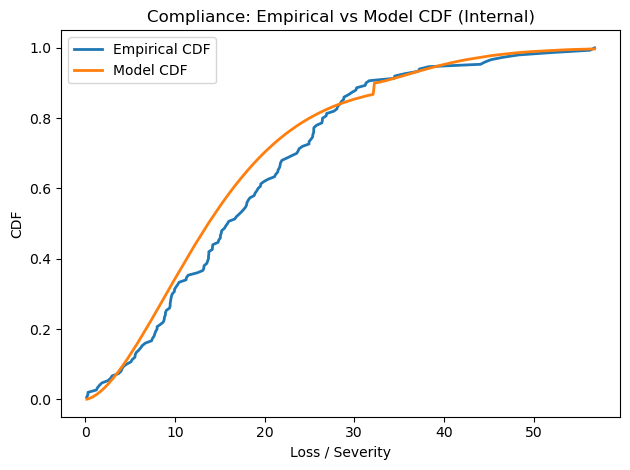

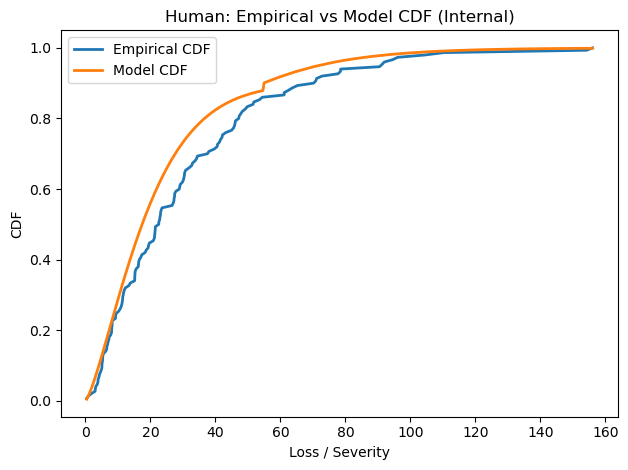

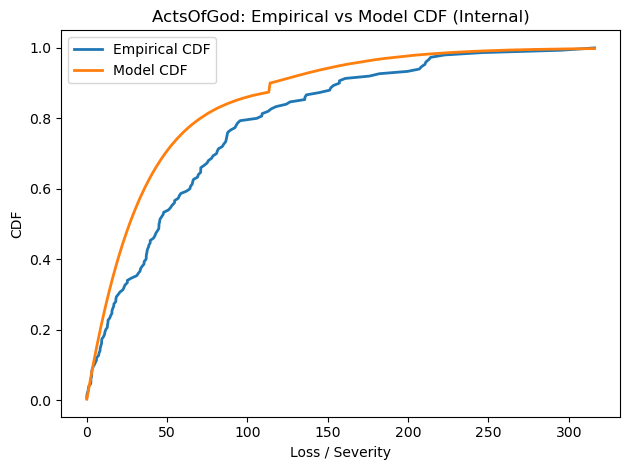

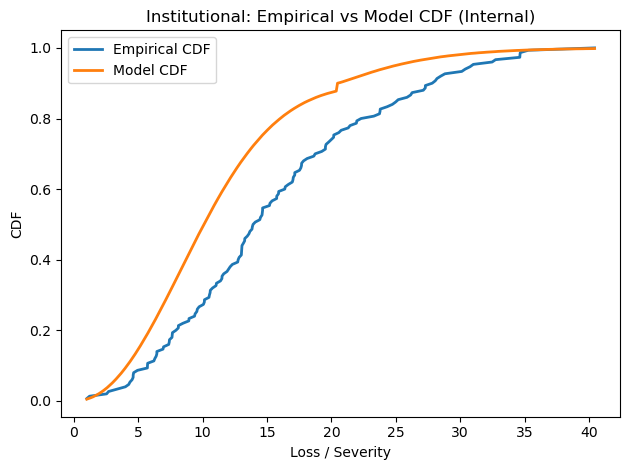

In [24]:
for cat in categories:
    ref = internal_df.loc[internal_df["category"] == cat, "loss"].to_numpy()
    plot_empirical_vs_model_cdf(ref, models[cat], title=f"{cat}: Empirical vs Model CDF (Internal)")


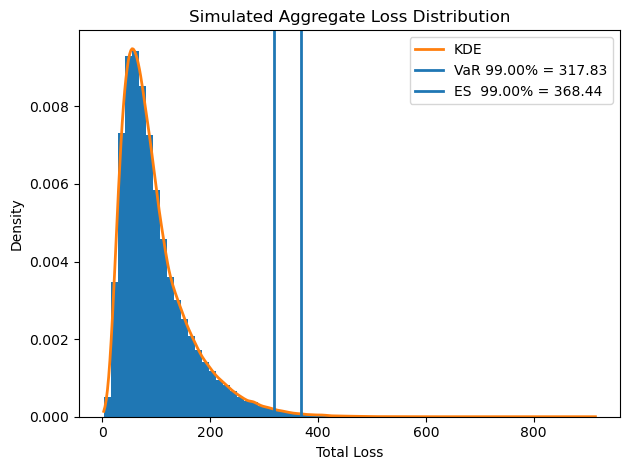

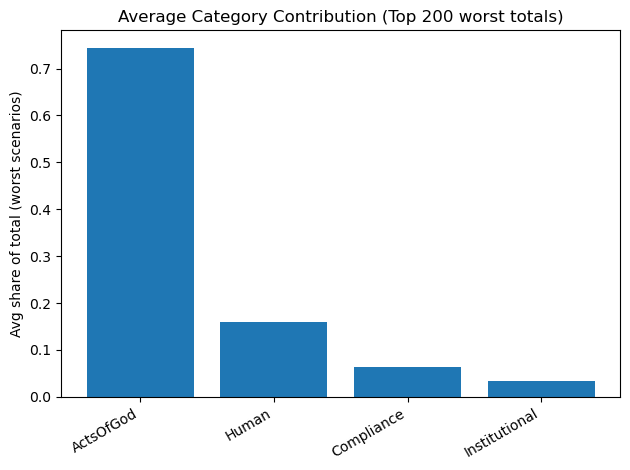

In [26]:
plot_aggregate_distribution(sim["Total"].to_numpy(), alpha=alpha, bins=70)
plot_category_contributions(sim, top_k=200)
